### TEXT PREPROCESSING

In [1]:
import nltk
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from ast import literal_eval
import re, string
import pandas as pd


df =  pd.read_csv("dataset.txt")
tweets = df['tweet'].tolist()

def preprocess_word(w):
    # Removes punctuation
    
    translator = str.maketrans('', '', string.punctuation)
    punctuation = w.translate(translator)

    return punctuation


def preprocessing(x):
    # Returns a nested list of the processed sentences
    
    mentions = [re.sub(r'@\w+',"", sent) for sent in tweets] #removes mentions
    numbers = [re.sub('[0-9]+', "", sent) for sent in mentions] #removes numbers
    links = [re.sub(r'http\S+', "", sent) for sent in numbers] #removes links
    
    lower = [[sent.lower()] for sent in links] #lower text
    in_list = [word for sent in lower for word in sent]
    word_tokenized = [word_tokenize(sent) for sent in in_list]
    word_tokenized = [sent for sent in word_tokenized if sent] #word tokenization
    
    for _id, sent in enumerate(word_tokenized):
        word_tokenized[_id] =  [preprocess_word(w) for w in sent]

    words = [[word for word in sent if word != '' and word != 'rt' and len(word)>1] for sent in word_tokenized] #removes useless words
    sentences = [sent for sent in words if sent] #removes empty sentences

    return sentences

text = preprocessing(tweets)

### BAG OF WORDS 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from ast import literal_eval

try: 
    assert(literal_eval(str(text)) == text.copy())
except AssertionError:
    print('failed to convert')
    
final_str = ([" ".join(x) for x in text])

count_vect = CountVectorizer()
bow = count_vect.fit_transform(final_str).toarray()
print(bow)

[[1 0 0 ... 0 2 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 ...
 [0 1 0 ... 0 2 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [3]:
vocab = count_vect.get_feature_names()

In [4]:
#Returns the frequency of every word in total
sumindex = [sum(x) for x in zip(*bow)]

### TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
tfidf = count_vect.fit_transform(final_str).toarray()
print(tfidf)

[[1 0 0 ... 0 2 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 ...
 [0 1 0 ... 0 2 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


### EMBEDDINGS 

In [6]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np

model = Word2Vec(sentences=text, window=5, min_count=1, workers=4)
model.save("word2vec.model")

vector = model.wv['no'] #returns numpy vector of a word
sims = model.wv.most_similar('no', topn=10) #returns similar words

embeddings = [model.wv[word] for word in text]

C:\Users\Angelina\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Calculate the word vector average for every sentence:

In [7]:
v_average = []
for i in text:
    av = np.mean(model.wv[i], axis=0)
    v_average.append(av)

In [8]:
from sklearn.decomposition import IncrementalPCA  
from sklearn.manifold import TSNE                 
import numpy as np                                  


def reduce_dimensions(model):
    num_dimensions = 2 


    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key) 

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(autosize=True)
    plt.scatter(x_vals, y_vals)

    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)

### SYNTAX

In [9]:
def flatten_list(x):
#Takes a nested list and converts it into a list of elements
#where every sublist is a new element

    new_list = [] 
    
    for sent in x:
        sentences = " ".join(sent)
        new_list.append(sentences)
    
    return new_list

new = flatten_list(text)
print(new)

['as woman you should nt complain about cleaning up your house amp as man you should always take the trash out', 'boy dats cold tyga dwn bad for cuffin dat hoe in the st place', 'dawg you ever fuck bitch and she start to cry you be confused as shit', 'she look like tranny', 'the shit you hear about me might be true or it might be faker than the bitch who told it to ya', 'the shit just blows me claim you so faithful and down for somebody but still fucking with hoes', 'can not just sit up and hate on another bitch got too much shit going on', 'cause tired of you big bitches coming for us skinny girls', 'amp you might not get ya bitch back amp thats that', 'hobbies include fighting mariam bitch', 'keeks is bitch she curves everyone lol walked into conversation like this smh', 'murda gang bitch its gang land', 'so hoes that smoke are losers yea go on ig', 'bad bitches is the only thing that like', 'bitch get up off me', 'bitch nigga miss me with it', 'bitch plz whatever', 'bitch who do you

In [10]:
import spacy

def dependency_parsing(x):
# Returns a nested list of syntactic labels

    nlp = spacy.load("en_core_web_sm")
    dependencies = []
    for sent in x:
        doc = nlp(sent)
        new_list = [token.dep_ for token in doc]
        dependencies.append(new_list)
        
    return dependencies

dep = dependency_parsing(new)

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import string
import pprint
%matplotlib inline

In [12]:
#Append every word to a wordset
wordset = set()
for sentence in text:
    for word in sentence:
        wordset.add(word)

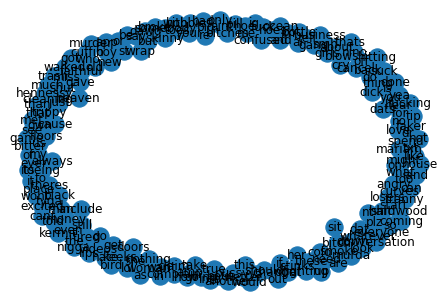

In [13]:
#Add every word as a node
base_graph = nx.Graph()
base_graph.add_nodes_from(wordset)
nx.draw(base_graph, with_labels=True)

In [14]:
repr = {}

nlp = spacy.load("en_core_web_sm")

for sentence_id, sentence_contents in enumerate(new):
    sentence_graph = base_graph.copy()
    processed_sentence =  nlp(' '.join(new))
    
print(processed_sentence)

as woman you should nt complain about cleaning up your house amp as man you should always take the trash out boy dats cold tyga dwn bad for cuffin dat hoe in the st place dawg you ever fuck bitch and she start to cry you be confused as shit she look like tranny the shit you hear about me might be true or it might be faker than the bitch who told it to ya the shit just blows me claim you so faithful and down for somebody but still fucking with hoes can not just sit up and hate on another bitch got too much shit going on cause tired of you big bitches coming for us skinny girls amp you might not get ya bitch back amp thats that hobbies include fighting mariam bitch keeks is bitch she curves everyone lol walked into conversation like this smh murda gang bitch its gang land so hoes that smoke are losers yea go on ig bad bitches is the only thing that like bitch get up off me bitch nigga miss me with it bitch plz whatever bitch who do you love black bottle amp bad bitch broke bitch cant tel

In [15]:
#Add edges between the nodes according to syntactic relations
for token in processed_sentence:
    nodeA = token.text
    nodeB = token.head.text
    #print('\tadding edge between', nodeA, 'and', nodeB)
    sentence_graph.add_edge(nodeA, nodeB)
    sentence_representation =  nx.adjacency_matrix(sentence_graph) #sparse matrix
    #print('\t sparse matrix has ',sentence_representation.count_nonzero(),'nonzero elements')
    repr[sentence_id] = sentence_representation

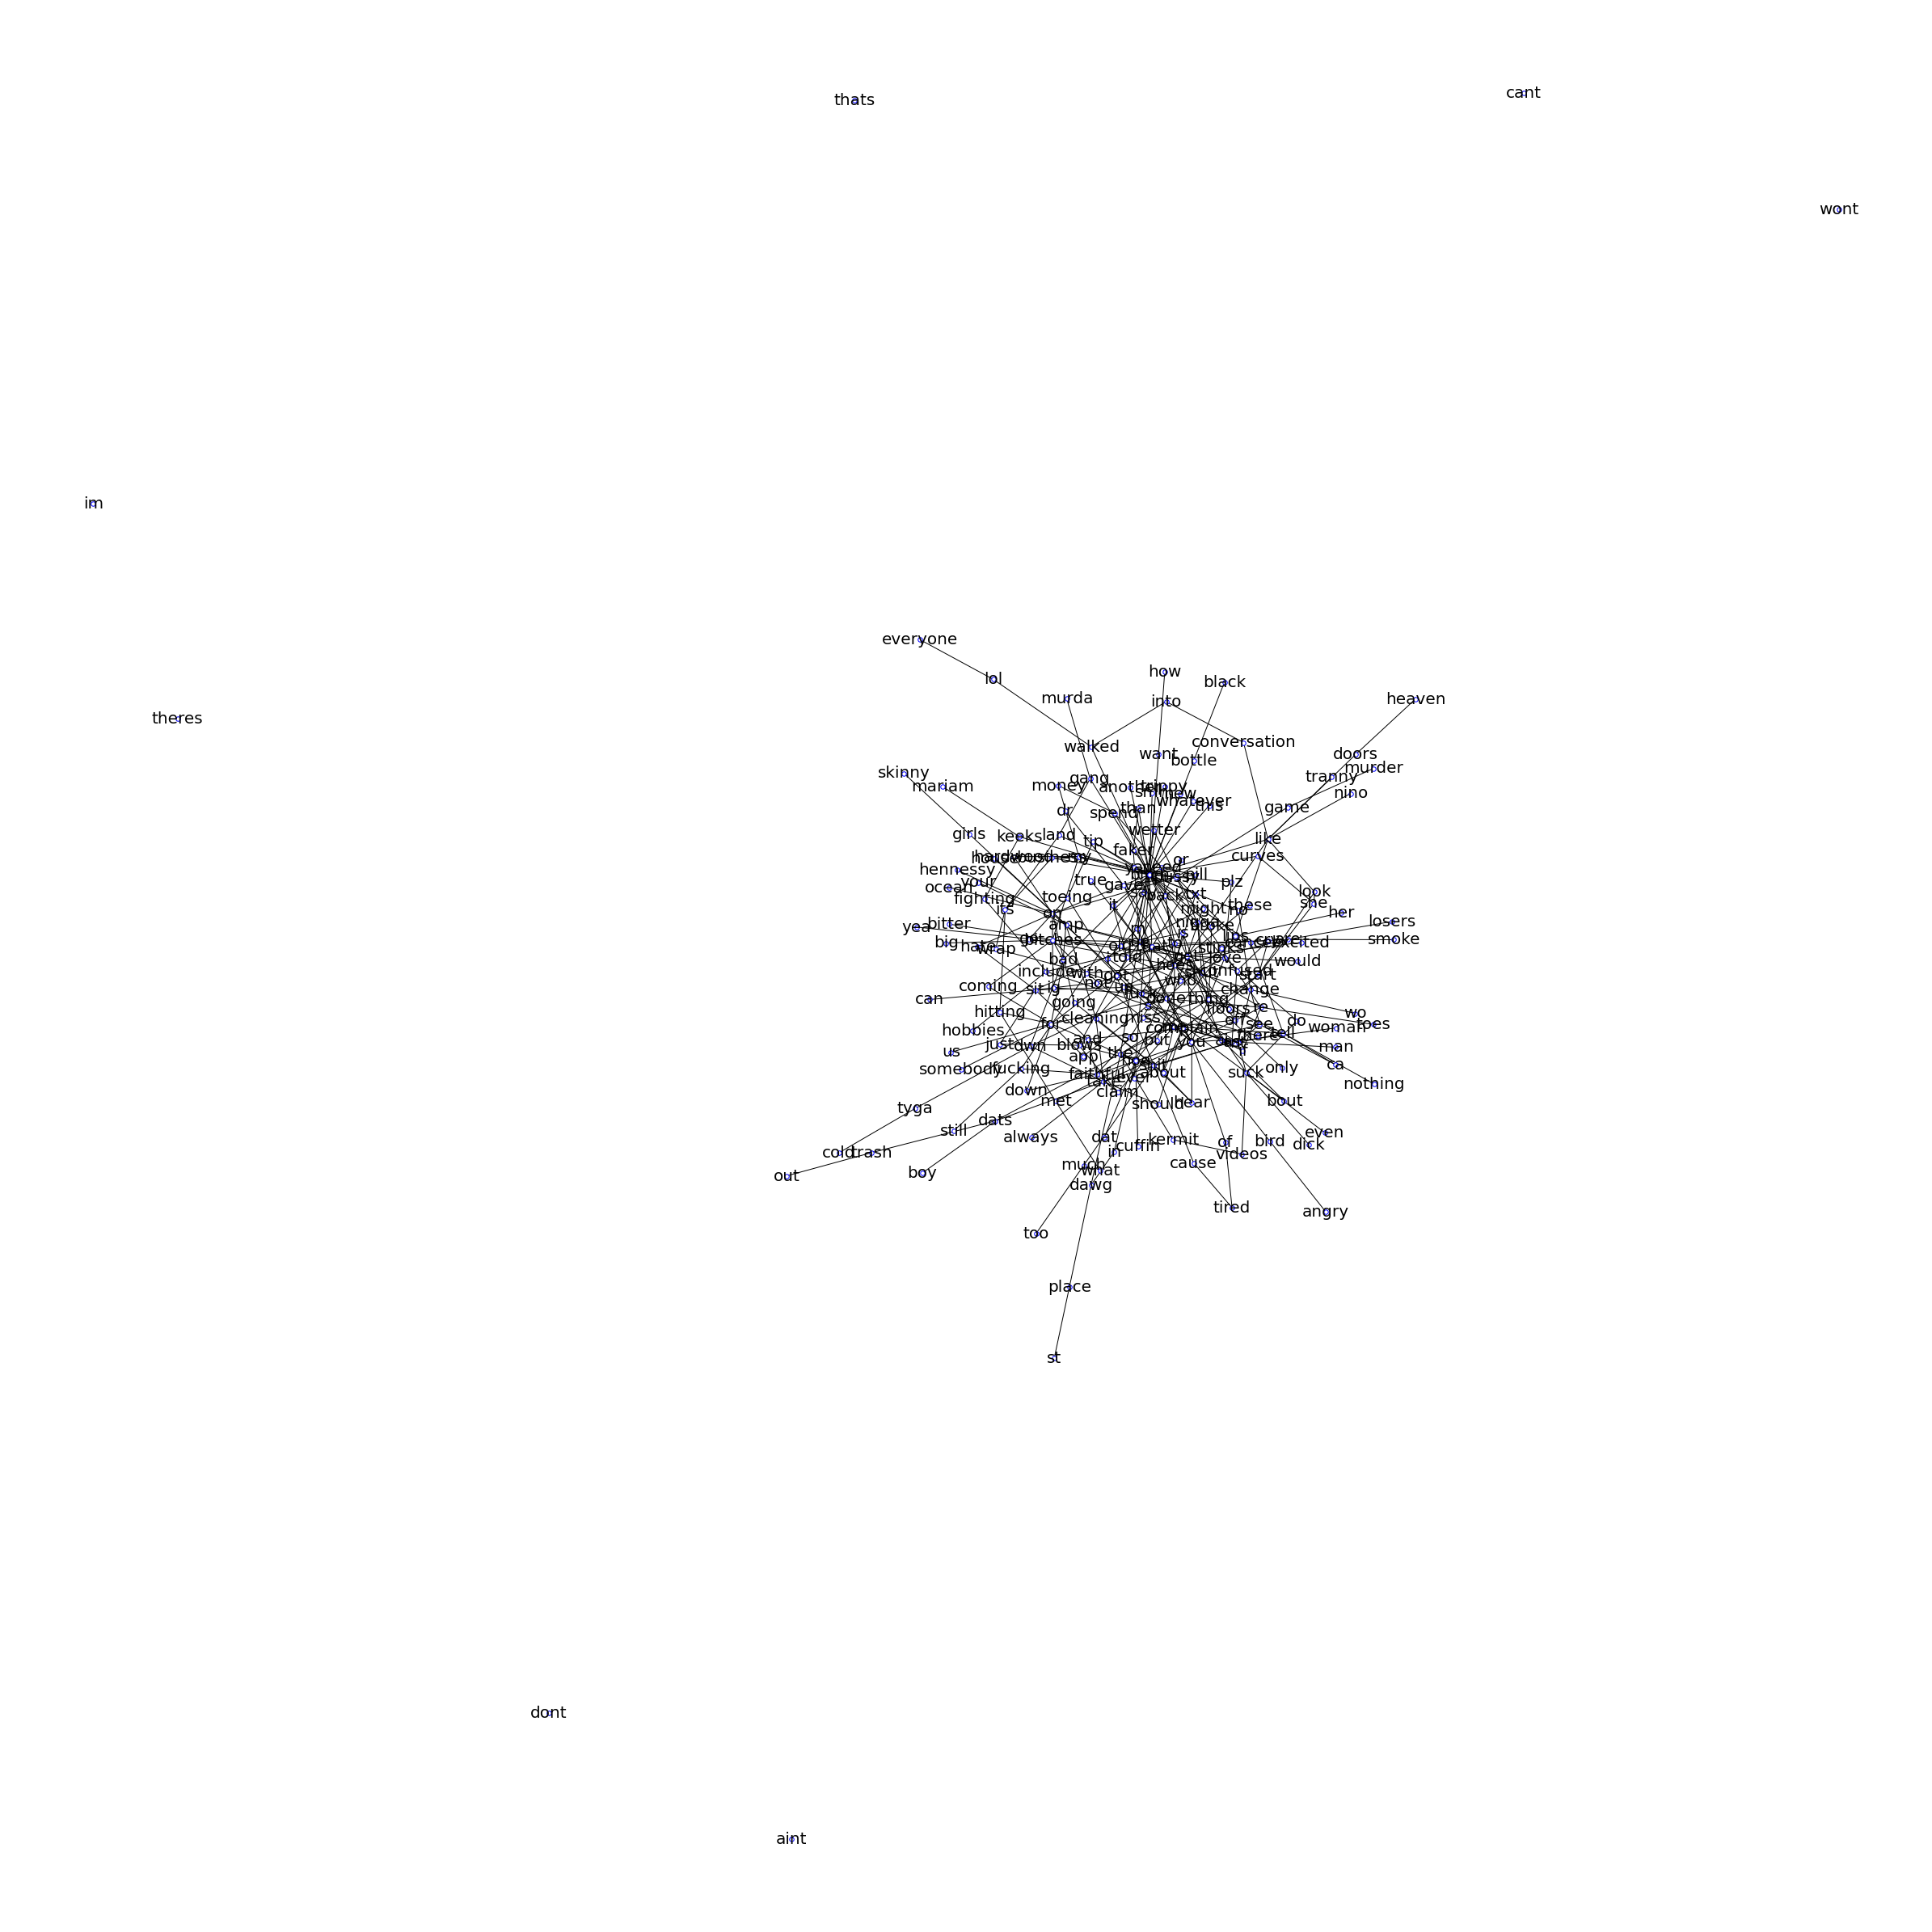

In [16]:
options = {
    "font_size": 20,
    "node_size": 30,
    "node_color": "white",
    "edgecolors": 'blue',
    "linewidths": 1,
    "width": 1,
}
plt.figure(3,figsize=(33,33)) 
nx.draw(sentence_graph, with_labels=True, **options)

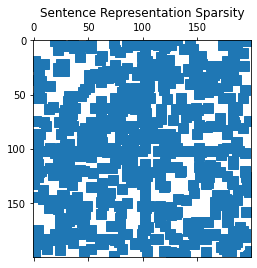

In [17]:
%matplotlib inline
plt.spy(sentence_representation)
plt.title("Sentence Representation Sparsity");

In [18]:
print(sentence_representation)

  (0, 102)	1
  (0, 132)	1
  (1, 19)	1
  (1, 24)	1
  (1, 36)	1
  (1, 116)	1
  (1, 125)	1
  (1, 178)	1
  (1, 180)	1
  (1, 194)	1
  (1, 197)	1
  (1, 198)	1
  (2, 53)	1
  (2, 74)	1
  (3, 109)	1
  (3, 144)	1
  (4, 86)	1
  (4, 94)	1
  (4, 114)	1
  (4, 126)	1
  (4, 174)	1
  (4, 176)	1
  (4, 186)	1
  (4, 187)	1
  (5, 25)	1
  :	:
  (189, 102)	1
  (190, 172)	1
  (192, 12)	1
  (192, 53)	1
  (192, 81)	1
  (192, 175)	1
  (193, 24)	1
  (194, 1)	1
  (194, 46)	1
  (194, 104)	1
  (194, 120)	1
  (194, 121)	1
  (194, 178)	1
  (194, 181)	1
  (194, 199)	1
  (195, 126)	1
  (195, 158)	1
  (196, 132)	1
  (197, 1)	1
  (197, 198)	1
  (198, 1)	1
  (198, 74)	1
  (198, 139)	1
  (198, 197)	1
  (199, 194)	1


#### DataFrame

In [19]:
A = pd.DataFrame(columns=['Tweets','Class','BoW','Embeddings'])
A['Tweets'] = [sent for sent in text]

In [20]:
A['Class'] = df['class']
print(A)

                                               Tweets  Class  BoW Embeddings
0   [as, woman, you, should, nt, complain, about, ...      2  NaN        NaN
1   [boy, dats, cold, tyga, dwn, bad, for, cuffin,...      1  NaN        NaN
2   [dawg, you, ever, fuck, bitch, and, she, start...      1  NaN        NaN
3                           [she, look, like, tranny]      1  NaN        NaN
4   [the, shit, you, hear, about, me, might, be, t...      1  NaN        NaN
5   [the, shit, just, blows, me, claim, you, so, f...      1  NaN        NaN
6   [can, not, just, sit, up, and, hate, on, anoth...      1  NaN        NaN
7   [cause, tired, of, you, big, bitches, coming, ...      1  NaN        NaN
8   [amp, you, might, not, get, ya, bitch, back, a...      1  NaN        NaN
9         [hobbies, include, fighting, mariam, bitch]      1  NaN        NaN
10  [keeks, is, bitch, she, curves, everyone, lol,...      1  NaN        NaN
11              [murda, gang, bitch, its, gang, land]      1  NaN        NaN

#### Frequency & Embeddings lists

In [21]:
wfrequency_list = []
for sent in text:
    for word in sent:
        ind = vocab.index(word)
        #print('\n',word, '\nIndex:', ind)
        freq = sumindex[ind]
        #print("BOW frequency:", freq)
        wfrequency_list.append(freq)

In [22]:
wembeddings_list = []
for l in embeddings:
    for subl in l:
        wembeddings_list.append(subl)

### CLASSIFICATION

#### Classification using Bag-of-Words:

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

In [24]:
x = bow
y = df['class'].astype(int)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
logr = LogisticRegression()
logr.fit(x_train, y_train)
bow_predictions = logr.predict(x_test)
print(bow_predictions)

[1 1 1 1 1 1 1 1 1]


In [26]:
bow_report = classification_report(y_test, bow_predictions)
print(bow_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



#### Classification using embeddings:

In [27]:
v_train, v_test, y_train, y_test = train_test_split(v_average, y, test_size=0.25, random_state=0)
logr.fit(v_train, y_train)
emb_predictions = logr.predict(v_test)
print(emb_predictions)

[1 1 1 1 1 1 1 1 1]


In [28]:
emb_report = classification_report(y_test, emb_predictions)
print(emb_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



#### Classification using both Bag-of-Words and embeddings: 

In [29]:
conc = np.concatenate([bow, v_average], axis=1)

In [30]:
c_train, c_test, y_train, y_test = train_test_split(conc, y, test_size=0.25, random_state=0)
logr.fit(c_train, y_train)
bow_emb_predictions = logr.predict(c_test)
print(bow_emb_predictions)

[1 1 1 1 1 1 1 1 1]


In [31]:
bow_emb_report = classification_report(y_test, bow_emb_predictions)
print(bow_emb_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



#### Classification using syntax

In [33]:
g_train, g_test, y_train, y_test = train_test_split(repr, y, test_size=0.25, random_state=0)
logr.fit(g_train, y_train)
bow_predictions = logr.predict(g_test)
print(syntax_predictions)

ValueError: Found input variables with inconsistent numbers of samples: [1, 35]